In [ ]:
!pip install torch torchvision timm


In [ ]:
!pip install timm -U

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import StepLR

In [ ]:
dataset_path = "/content/drive/MyDrive/images"

# Step 4: Define transformations
# Since DeiT expects 224x224 images, we resize them accordingly
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std dev for RGB
])

# Step 5: Load dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
class_names = full_dataset.classes
print("Classes:", class_names)

Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
# Number of classes
num_classes = len(class_names)

# Create CrossViT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('crossvit_15_240', pretrained=True)  # Select the model variant
if isinstance(model.head, nn.ModuleList):
    # Iterate through all heads in the ModuleList and replace their last layer
    for i in range(len(model.head)):
        model.head[i] = nn.Linear(model.head[i].in_features, num_classes)
elif hasattr(model.head, 'fc'):
    # If there is an attribute `fc` in the head, replace it
    model.head.fc = nn.Linear(model.head.fc.in_features, num_classes)
else:
    # Directly replace the model head if it’s a single layer
    model.head = nn.Linear(model.head.in_features, num_classes)


# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


model = model.to(device)



In [ ]:
# Define your optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Training function
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()  # Backward pass
        optimizer.step()  # Optimizer step

        # Accumulate loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Store predictions and labels for metrics calculation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return epoch_loss, epoch_acc, precision, recall, f1

# Validation function
def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    val_loss = running_loss / total
    val_acc = 100 * correct / total

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return val_loss, val_acc, precision, recall, f1

# Tracking metrics for visualization
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_precisions, train_recalls, train_f1s = [], [], []
val_precisions, val_recalls, val_f1s = [], [], []



In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training step
    train_loss, train_acc, train_precision, train_recall, train_f1 = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validation step
    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(
        model, val_loader, criterion, device
    )

    # Update learning rate
    scheduler.step()

    # Store metrics for visualization
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    # Print metrics for this epoch
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1:.2f}\n")


Epoch 1/10
Training Loss: 0.1360, Accuracy: 95.35%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95
Validation Loss: 0.0053, Accuracy: 99.92%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 2/10
Training Loss: 0.0102, Accuracy: 99.71%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0008, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 3/10
Training Loss: 0.0005, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0004, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 4/10
Training Loss: 0.0003, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0003, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 5/10
Training Loss: 0.0002, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0002, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 6/10
Training Loss: 0.0002, Accuracy: 100.00%, 

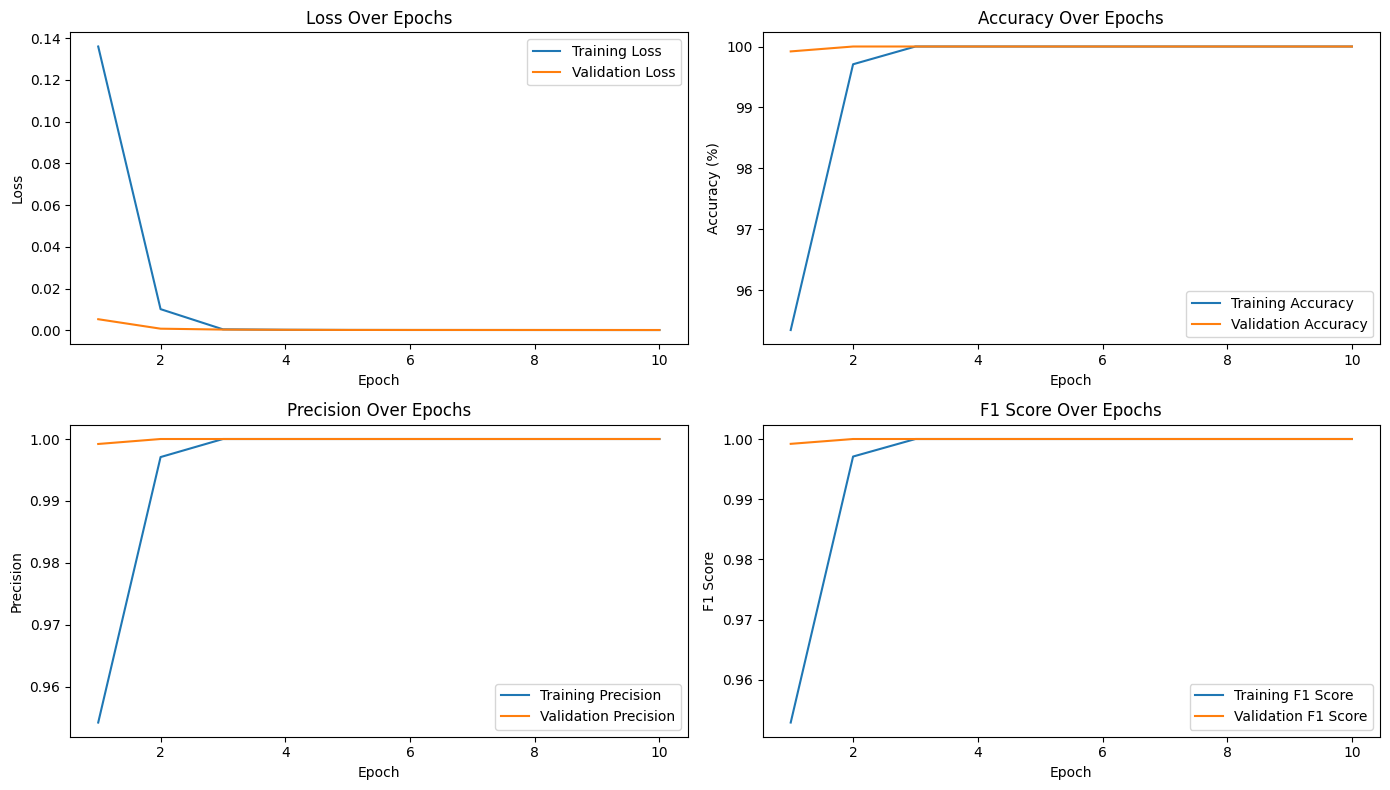

In [ ]:
epochs = np.arange(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Training Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Over Epochs')
plt.legend()

# Plot F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, label='Training F1 Score')
plt.plot(epochs, val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()